In [41]:
import datetime as dt

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from matplotlib.lines import Line2D
import numpy as np

In [2]:
# from https://www.gov.uk/government/statistical-data-sets/uk-house-price-index-data-downloads-october-2022

prices = pd.read_csv('data/Average-prices-2022-10.csv', parse_dates=['Date'])
prices = prices[prices['Date'] >= '01-01-1995']

In [3]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135730 entries, 3309 to 139038
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              135730 non-null  datetime64[ns]
 1   Region_Name       135730 non-null  object        
 2   Area_Code         135730 non-null  object        
 3   Average_Price     135730 non-null  float64       
 4   Monthly_Change    135288 non-null  float64       
 5   Annual_Change     130846 non-null  float64       
 6   Average_Price_SA  4674 non-null    float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 8.3+ MB


In [4]:
all_wales = prices[(prices['Area_Code'].str.startswith('W')) & (prices['Region_Name'] != 'Wales')].copy()

In [24]:
wales_avg = prices[prices['Region_Name'] == 'Wales']
newport = prices[prices['Region_Name'] == 'Newport']
rest_wales = prices[(prices['Area_Code'].str.startswith('W')) & (prices['Region_Name'] != 'Wales') & (prices['Region_Name'] != 'Newport')]

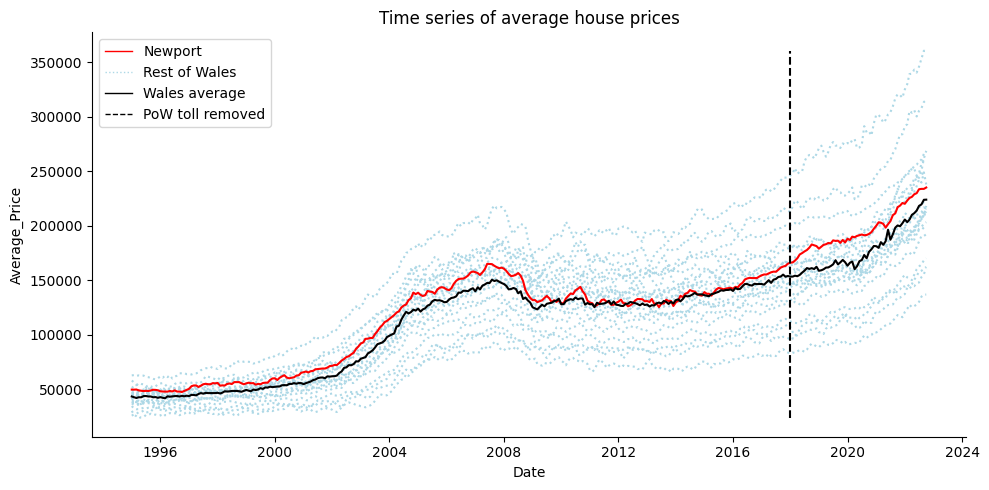

In [162]:
fig, ax = plt.subplots(figsize=(10, 5))

palette = sns.color_palette(['lightblue'], len(rest_wales.Region_Name.unique()))

ax = sns.lineplot(data=rest_wales, x='Date', y='Average_Price', hue='Region_Name', legend=False, palette=palette, linestyle=':')
ax = sns.lineplot(data=newport, x='Date', y='Average_Price', color='red')
ax = sns.lineplot(data=wales_avg, x='Date', y='Average_Price', color='black')
plt.vlines(dt.datetime(2018, 1, 1), ymin=min(all_wales['Average_Price']), ymax=max(all_wales['Average_Price']),
           linestyles='dashed', colors='black', label='PoW toll removed')

legend_lines = [Line2D([0], [0], color='red', lw=1),
                Line2D([0], [0], color='lightblue', linestyle=':', lw=1),
                Line2D([0], [0], color='black', lw=1),
                Line2D([0], [0], color='black', linestyle='dashed', lw=1)]

ax.legend(legend_lines, ['Newport', 'Rest of Wales', 'Wales average', 'PoW toll removed'])
sns.despine()
plt.title('Time series of average house prices')
plt.tight_layout()
plt.savefig('outptime_series.png')
plt.show()

# Diff-in-diff

In [7]:
some_las = prices[(prices['Region_Name'] == 'Newport') | 
                  (prices['Region_Name'] == 'Cardiff')]

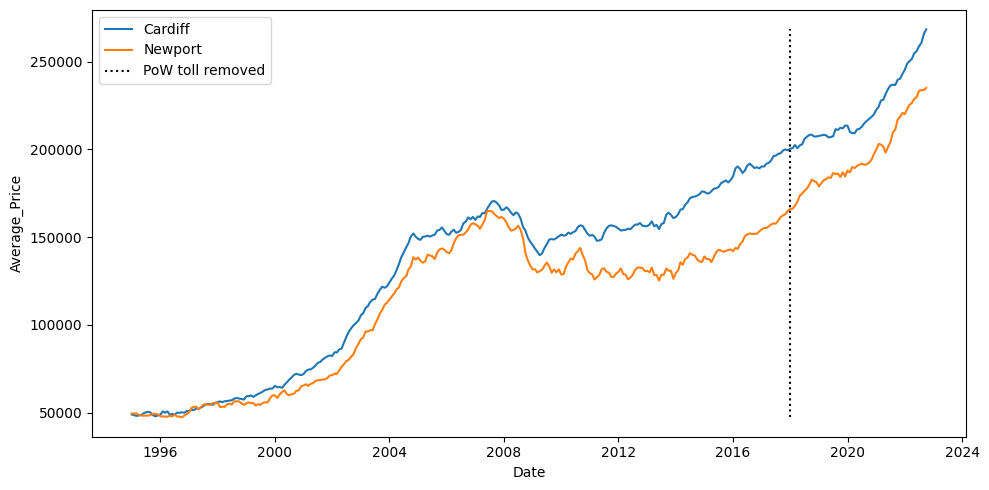

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))

ax = sns.lineplot(data=some_las, x='Date', y='Average_Price', hue='Region_Name')
plt.vlines(dt.datetime(2018, 1, 1), ymin=min(some_las['Average_Price']), ymax=max(some_las['Average_Price']),
           linestyles=':', colors='black', label='PoW toll removed')
plt.legend()
plt.tight_layout()

plt.show()

In [9]:
some_las_pvt = some_las.pivot(index='Date', columns='Region_Name', values='Average_Price').reset_index()
some_las_pvt['ratio'] = some_las_pvt['Newport'] / some_las_pvt['Cardiff']

In [10]:
some_las_pvt

Region_Name,Date,Cardiff,Newport,ratio
0,1995-01-01,48889.62657,49472.32324,1.011919
1,1995-02-01,48470.68754,49430.55412,1.019803
2,1995-03-01,48121.83427,49545.96771,1.029594
3,1995-04-01,48276.85280,48717.06324,1.009118
4,1995-05-01,48593.36643,48459.02872,0.997235
...,...,...,...,...
329,2022-06-01,255953.46955,229775.77922,0.897725
330,2022-07-01,258736.93329,233401.23142,0.902079
331,2022-08-01,260733.85335,233727.47394,0.896422
332,2022-09-01,265775.02707,233718.62567,0.879385


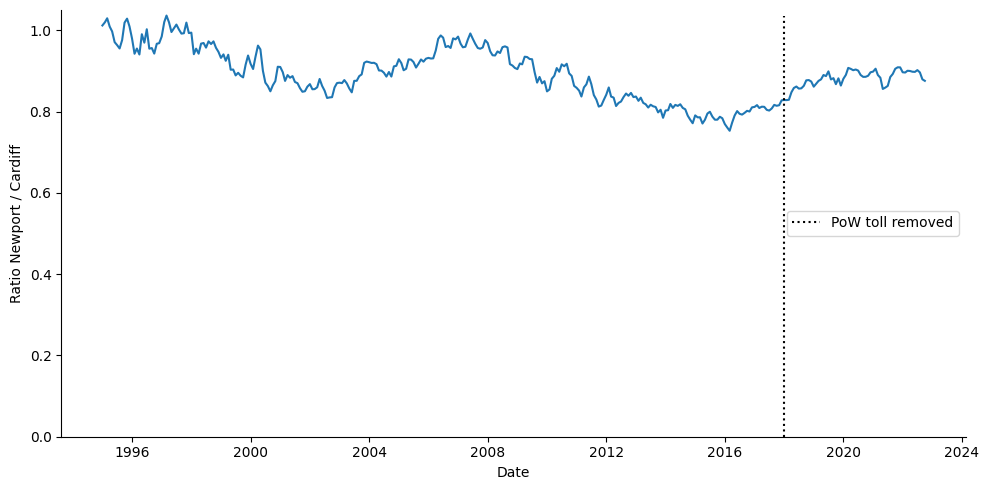

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))

ax = sns.lineplot(data=some_las_pvt, x='Date', y='ratio')
plt.vlines(dt.datetime(2018, 1, 1), ymin=0, ymax=max(some_las_pvt['ratio']),
           linestyles=':', colors='black', label='PoW toll removed')
plt.ylim(0, 1.05)
plt.ylabel('Ratio Newport / Cardiff')
plt.legend(loc='center right')
plt.tight_layout()
sns.despine()
plt.show()

In [12]:
np_2016 = int(some_las[(some_las['Date'] == '01-01-2016') & (some_las['Region_Name'] == 'Newport')]['Average_Price'])
np_2020 = int(some_las[(some_las['Date'] == '01-01-2020') & (some_las['Region_Name'] == 'Newport')]['Average_Price'])

ca_2016 = int(some_las[(some_las['Date'] == '01-01-2016') & (some_las['Region_Name'] == 'Cardiff')]['Average_Price'])
ca_2020 = int(some_las[(some_las['Date'] == '01-01-2020') & (some_las['Region_Name'] == 'Cardiff')]['Average_Price'])

In [13]:
diff_in_diff = (np_2020 - np_2016) - (ca_2020 - ca_2016)
diff_in_diff

17072

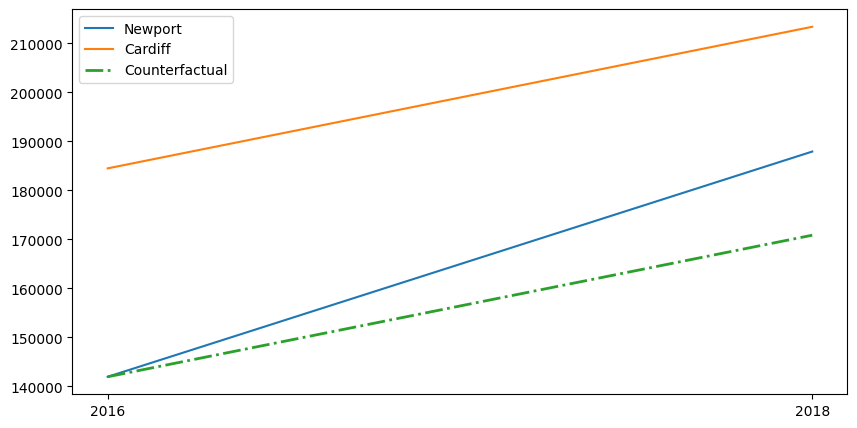

In [14]:
plt.figure(figsize=(10,5))
plt.plot(['2016', '2018'], [np_2016, np_2020], label='Newport')
plt.plot(['2016', '2018'], [ca_2016, ca_2020], label='Cardiff')

plt.plot(['2016', '2018'], [np_2016, np_2016+(ca_2020-ca_2016)],
         label="Counterfactual", lw=2, color="C2", ls="-.")

plt.legend()

plt.show()

# Synthetic control

In [15]:
rest_wales = prices[(prices['Area_Code'].str.startswith('W')) & (prices['Region_Name'] != 'Wales') & (prices['Region_Name'] != 'Newport')]
rest_wales_avg = rest_wales.groupby(by='Date')['Average_Price'].mean().reset_index()
rest_wales_avg['Region_Name'] = 'Rest of Wales'

newport = prices[prices['Region_Name'] == 'Newport'][['Date', 'Average_Price', 'Region_Name']]

In [16]:
data = pd.concat([newport, rest_wales_avg])

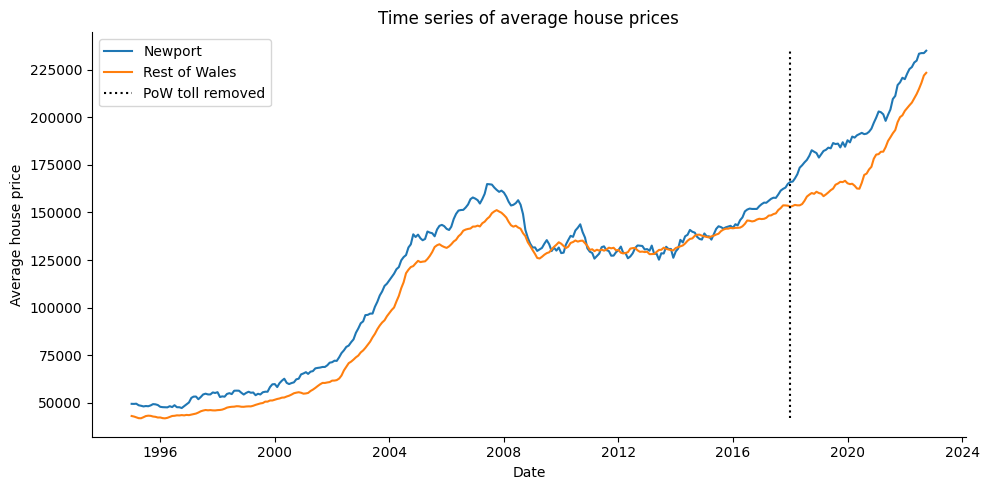

In [155]:
fig, ax = plt.subplots(figsize=(10, 5))

ax = sns.lineplot(data=data, x='Date', y='Average_Price', hue='Region_Name')
plt.vlines(dt.datetime(2018, 1, 1), ymin=min(data['Average_Price']), ymax=max(data['Average_Price']),
           linestyles=':', colors='black', label='PoW toll removed')
plt.ylabel('Average house price')
plt.title('Time series of average house prices')
sns.despine()
plt.legend()
plt.tight_layout()
plt.savefig('output/newport_vs_avg.png')
plt.show()

In [18]:
all_wales_prices = prices[(prices['Area_Code'].str.startswith('W')) & (prices['Region_Name'] != 'Wales')][['Date', 'Region_Name', 'Average_Price']]

In [19]:
all_wales_prices_pvt = all_wales_prices[all_wales_prices['Date'] < '01-01-2018'].pivot(index='Date', columns='Region_Name', values='Average_Price')

In [20]:
y = all_wales_prices_pvt['Newport'].values
X = all_wales_prices_pvt.drop(columns='Newport').values

In [21]:
weights_lr = LinearRegression(fit_intercept=False).fit(X, y).coef_
weights_lr.round(3)

array([ 0.181,  0.013,  0.222,  0.28 ,  0.194, -0.047,  0.136,  0.139,
        0.324, -0.31 , -0.219, -0.126,  0.055, -0.212,  0.031, -0.09 ,
        0.105,  0.089,  0.219, -0.333,  0.512])

In [22]:
wales_synth_lr = (all_wales_prices[all_wales_prices['Region_Name'] != 'Newport']
                  .pivot(index='Date', columns="Region_Name")["Average_Price"]
                  .values.dot(weights_lr))

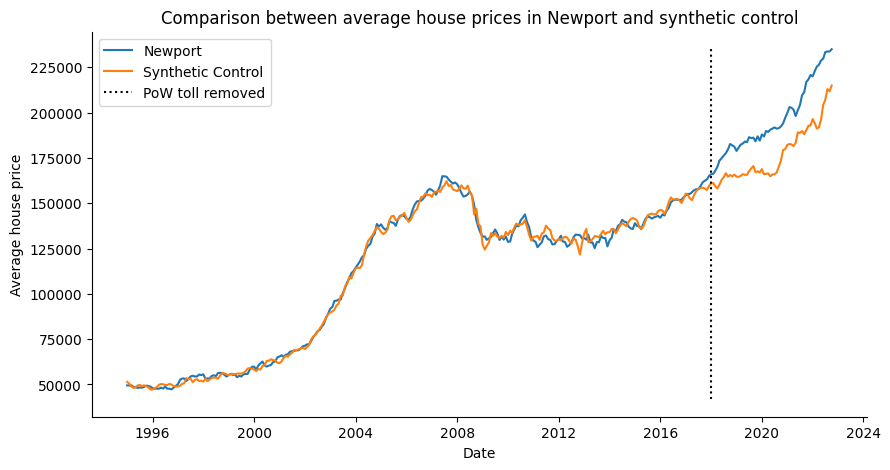

In [158]:
plt.figure(figsize=(10,5))
plt.plot(all_wales_prices['Date'].unique(), all_wales_prices[all_wales_prices['Region_Name'] == 'Newport']["Average_Price"], label="Newport")
plt.plot(all_wales_prices['Date'].unique(), wales_synth_lr, label="Synthetic Control")
plt.vlines(dt.datetime(2018, 1, 1), ymin=min(data['Average_Price']), ymax=max(data['Average_Price']),
           linestyles=':', colors='black', label='PoW toll removed')
plt.ylabel("Average house price")
plt.xlabel("Date")
plt.title('Comparison between average house prices in Newport and synthetic control')
plt.legend()
sns.despine()
plt.savefig('output/newport_vs_sc.png')
plt.show()


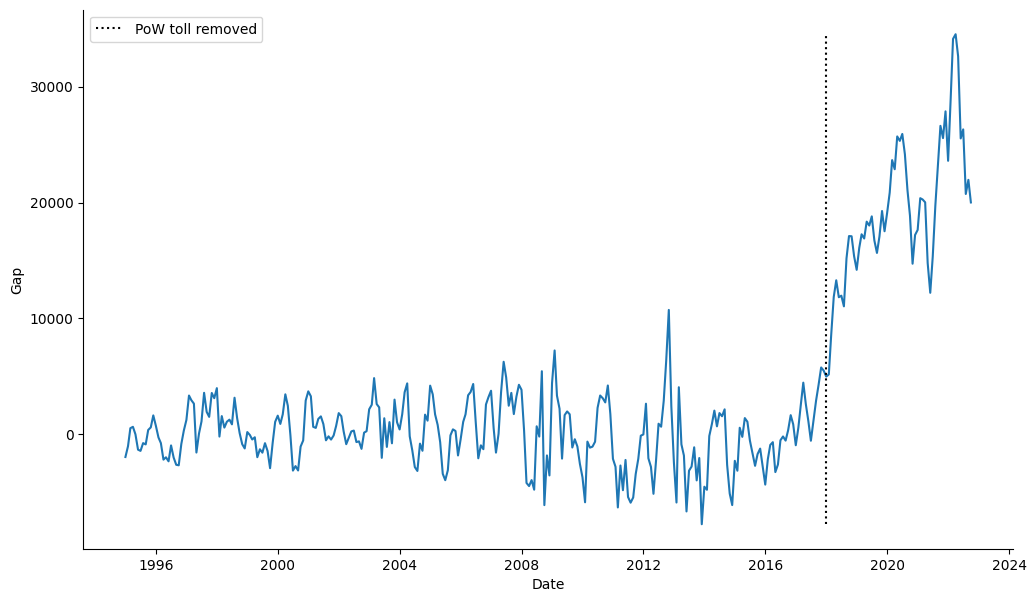

In [74]:

plt.figure(figsize=(12, 7))
plt.plot(all_wales_prices['Date'].unique(), all_wales_prices[all_wales_prices['Region_Name'] == 'Newport']["Average_Price"] - wales_synth_lr)
plt.vlines(dt.datetime(2018, 1, 1), 
           ymin=min(all_wales_prices[all_wales_prices['Region_Name'] == 'Newport']["Average_Price"] - wales_synth_lr),
           ymax=max(all_wales_prices[all_wales_prices['Region_Name'] == 'Newport']["Average_Price"] - wales_synth_lr),
           linestyles=':', colors='black', label='PoW toll removed')
plt.ylabel('Gap')
plt.xlabel("Date")
plt.legend()
sns.despine()
plt.savefig('output/gap.png')
plt.show()


In [59]:
def synthetic_control(region: str, data: pd.DataFrame) -> pd.DataFrame:
    
    inverted = data[data['Date'] < '01-01-2018'].pivot(index='Date', columns='Region_Name', values='Average_Price')

    y = inverted[region].values
    X = inverted.drop(columns=region).values

    weights_lr = LinearRegression(fit_intercept=False).fit(X, y).coef_

    synthetic = (all_wales_prices[all_wales_prices['Region_Name'] != region]
                .pivot(index='Date', columns="Region_Name")["Average_Price"]
                .values.dot(weights_lr))

    return data[data['Region_Name'] == region].assign(synthetic=synthetic)
    

In [60]:
list_la = all_wales_prices['Region_Name'].unique()

In [61]:
synthetic_las = [synthetic_control(x, all_wales_prices) for x in list_la] 

In [62]:
synthetic_las[0].tail()

,Date,Region_Name,Average_Price,synthetic
137348,2022-06-01,Powys,244481.06139,241619.009916
137723,2022-07-01,Powys,246066.40777,242510.448364
138119,2022-08-01,Powys,250364.17226,246474.016311
138610,2022-09-01,Powys,261591.01323,251020.566213
138960,2022-10-01,Powys,268531.48770,252566.968308


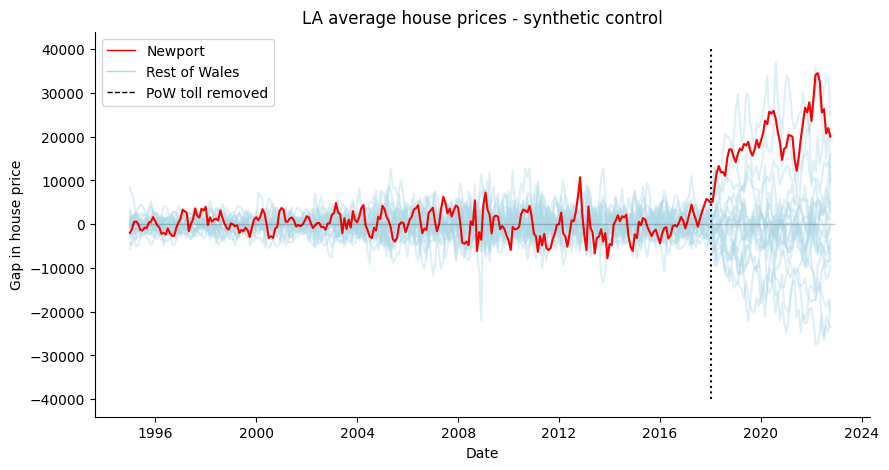

In [161]:
fig, ax = plt.subplots(figsize=(10, 5))

for la in synthetic_las:
    plt.plot(la['Date'], la['Average_Price'] - la['synthetic'], color='lightblue', alpha=0.4)

plt.plot(all_wales_prices['Date'].unique(), all_wales_prices[all_wales_prices['Region_Name'] == 'Newport']["Average_Price"] - wales_synth_lr, 
         color='red')
plt.vlines(dt.datetime(2018, 1, 1), ymin=-40000, ymax=40000, linestyles=':', colors='black', label='PoW toll removed')
plt.hlines(y=0, xmin=dt.date(1995, 1, 1), xmax=dt.date(2022, 12, 1), lw=1, alpha=0.2, color='black')

legend_lines = [Line2D([0], [0], color='red', lw=1),
                Line2D([0], [0], color='lightblue', lw=1),
                Line2D([0], [0], color='black', linestyle='dashed', lw=1)]

ax.legend(legend_lines, ['Newport', 'Rest of Wales', 'PoW toll removed'])

plt.title('LA average house prices - synthetic control')
plt.ylabel('Gap in house price')
plt.xlabel('Date')
sns.despine()
plt.savefig('output/gap_all.png')
plt.show()

In [149]:
effects = {la['Region_Name'].unique()[0]: np.mean(la[la['Date'] >= '2018-01-01']['Average_Price'] - la[la['Date'] >= '2018-01-01']['synthetic']) for la in synthetic_las}

effects_df = pd.DataFrame.from_dict(effects, orient='index').reset_index()
effects_df = effects_df.rename(columns={'index': 'la', 0: 'gap'}).sort_values('gap')


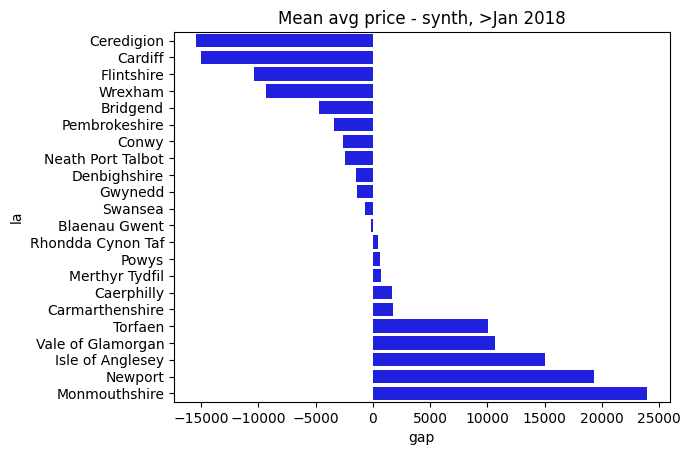

In [152]:
sns.barplot(data=effects_df, x='gap', y='la', orient='h', color='blue')
plt.title('Mean avg price - synth, >Jan 2018')
plt.show()